In [211]:
#imports
import numpy as np
import pandas as pd
import seaborn as sns
import pandas_datareader as dr
from math import sqrt
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from sqlalchemy import create_engine
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import silhouette_score

## Create our pipeline and define the classifier we plan to use for stocks within any of the 3 indices

In [359]:
preprocessor = Pipeline([
    ("scaler", MinMaxScaler())
])
kmeans_kwargs = {
    "init": "k-means++", 
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42
}
clf = Pipeline([
    (
        "kmeans",
     KMeans(
         **kmeans_kwargs
     ),
    ),
])
pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("clusterer", clf)
    ]
)

In [ ]:
sp500_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
nasdaq100_url = 'https://en.wikipedia.org/wiki/Nasdaq-100'

In [39]:
data_table = pd.read_html('https://en.wikipedia.org/wiki/Nasdaq-100')[3]['Ticker'].values
data_table

array(['ATVI', 'ADBE', 'AMD', 'ALXN', 'ALGN', 'GOOGL', 'GOOG', 'AMZN',
       'AEP', 'AMGN', 'ADI', 'ANSS', 'AAPL', 'AMAT', 'ASML', 'TEAM',
       'ADSK', 'ADP', 'BIDU', 'BIIB', 'BKNG', 'AVGO', 'CDNS', 'CDW',
       'CERN', 'CHTR', 'CHKP', 'CTAS', 'CSCO', 'CTSH', 'CMCSA', 'CPRT',
       'COST', 'CSX', 'DXCM', 'DOCU', 'DLTR', 'EBAY', 'EA', 'EXC', 'FB',
       'FAST', 'FISV', 'FOXA', 'FOX', 'GILD', 'IDXX', 'ILMN', 'INCY',
       'INTC', 'INTU', 'ISRG', 'JD', 'KDP', 'KLAC', 'KHC', 'LRCX', 'LULU',
       'MAR', 'MRVL', 'MTCH', 'MXIM', 'MELI', 'MCHP', 'MU', 'MSFT',
       'MRNA', 'MDLZ', 'MNST', 'NTES', 'NFLX', 'NVDA', 'NXPI', 'ORLY',
       'OKTA', 'PCAR', 'PAYX', 'PYPL', 'PTON', 'PEP', 'PDD', 'QCOM',
       'REGN', 'ROST', 'SGEN', 'SIRI', 'SWKS', 'SPLK', 'SBUX', 'SNPS',
       'TMUS', 'TSLA', 'TXN', 'TCOM', 'VRSN', 'VRSK', 'VRTX', 'WBA',
       'WDAY', 'XEL', 'XLNX', 'ZM'], dtype=object)

In [9]:

#read in the url and scrape ticker data
data_table = pd.read_html(sp500_url)
# tickers = data_table[0][1:]['Symbol'].values
tickers = data_table[0]['Symbol'].values

prices_list = []

for idx, ticker in enumerate(tickers):
    try:
        print(f"Working with ticker...:{ticker} and {len(tickers) - idx} left to go.")
        prices = dr.DataReader(ticker,'yahoo','01/01/2017')['Adj Close']
        prices = pd.DataFrame(prices)
        prices.columns = [ticker]
        prices_list.append(prices)
    except:
        print(f"Error with retrieving data for: {ticker}")
        pass
    prices_df = pd.concat(prices_list,axis=1)
prices_df.sort_index(inplace=True)


Working with ticker...:MMM and 505 left to go.
Working with ticker...:ABT and 504 left to go.
Working with ticker...:ABBV and 503 left to go.
Working with ticker...:ABMD and 502 left to go.
Working with ticker...:ACN and 501 left to go.
Working with ticker...:ATVI and 500 left to go.
Working with ticker...:ADBE and 499 left to go.
Working with ticker...:AMD and 498 left to go.
Working with ticker...:AAP and 497 left to go.
Working with ticker...:AES and 496 left to go.
Working with ticker...:AFL and 495 left to go.
Working with ticker...:A and 494 left to go.
Working with ticker...:APD and 493 left to go.
Working with ticker...:AKAM and 492 left to go.
Working with ticker...:ALK and 491 left to go.
Working with ticker...:ALB and 490 left to go.
Working with ticker...:ARE and 489 left to go.
Working with ticker...:ALXN and 488 left to go.
Working with ticker...:ALGN and 487 left to go.
Working with ticker...:ALLE and 486 left to go.
Working with ticker...:LNT and 485 left to go.
Working

Working with ticker...:ESS and 333 left to go.
Working with ticker...:EL and 332 left to go.
Working with ticker...:ETSY and 331 left to go.
Working with ticker...:EVRG and 330 left to go.
Working with ticker...:ES and 329 left to go.
Working with ticker...:RE and 328 left to go.
Working with ticker...:EXC and 327 left to go.
Working with ticker...:EXPE and 326 left to go.
Working with ticker...:EXPD and 325 left to go.
Working with ticker...:EXR and 324 left to go.
Working with ticker...:XOM and 323 left to go.
Working with ticker...:FFIV and 322 left to go.
Working with ticker...:FB and 321 left to go.
Working with ticker...:FAST and 320 left to go.
Working with ticker...:FRT and 319 left to go.
Working with ticker...:FDX and 318 left to go.
Working with ticker...:FIS and 317 left to go.
Working with ticker...:FITB and 316 left to go.
Working with ticker...:FE and 315 left to go.
Working with ticker...:FRC and 314 left to go.
Working with ticker...:FISV and 313 left to go.
Working wi

Working with ticker...:NUE and 159 left to go.
Working with ticker...:NVDA and 158 left to go.
Working with ticker...:NVR and 157 left to go.
Working with ticker...:ORLY and 156 left to go.
Working with ticker...:OXY and 155 left to go.
Working with ticker...:ODFL and 154 left to go.
Working with ticker...:OMC and 153 left to go.
Working with ticker...:OKE and 152 left to go.
Working with ticker...:ORCL and 151 left to go.
Working with ticker...:OTIS and 150 left to go.
Working with ticker...:PCAR and 149 left to go.
Working with ticker...:PKG and 148 left to go.
Working with ticker...:PH and 147 left to go.
Working with ticker...:PAYX and 146 left to go.
Working with ticker...:PAYC and 145 left to go.
Working with ticker...:PYPL and 144 left to go.
Working with ticker...:PNR and 143 left to go.
Working with ticker...:PBCT and 142 left to go.
Working with ticker...:PEP and 141 left to go.
Working with ticker...:PKI and 140 left to go.
Working with ticker...:PRGO and 139 left to go.
Wor

,MMM,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,...,WYNN,XEL,XRX,XLNX,XYL,YUM,ZBRA,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,156.767715,36.148453,51.374924,112.360001,108.617332,35.706703,103.480003,11.43,168.394165,9.972317,...,81.032707,36.135056,23.527445,55.070808,47.077194,58.647362,86.250000,100.094238,39.032848,52.175865
2017-01-04,157.005417,36.435421,52.099331,115.739998,108.878471,36.408356,104.139999,11.43,169.776047,9.886791,...,83.645470,36.295177,24.415272,54.669926,47.778847,58.860760,87.029999,101.014511,39.593296,52.682140
2017-01-05,156.468323,36.750153,52.494453,114.809998,107.246315,36.973591,105.910004,11.24,169.657593,9.758502,...,84.720230,36.295177,24.312834,54.007980,47.342682,59.055603,84.750000,101.663528,38.951492,52.506889
2017-01-06,156.926178,37.749912,52.510921,115.419998,108.468102,36.944351,108.300003,11.32,167.436676,10.109159,...,85.637459,36.401924,23.937212,55.052166,47.010826,59.770023,85.959999,101.673210,39.204601,52.672401
2017-01-09,156.080948,37.712887,52.856659,117.110001,107.255646,36.739704,108.570000,11.49,167.338013,9.861135,...,85.933945,35.850384,23.800617,55.061493,46.811699,59.937027,85.970001,103.649330,38.779747,52.526363


In [360]:
prices_df.head()

,MMM,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,...,WYNN,XEL,XRX,XLNX,XYL,YUM,ZBRA,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,156.767715,36.148453,51.374924,112.360001,108.617332,35.706703,103.480003,11.43,168.394165,9.972317,...,81.032707,36.135056,23.527445,55.070808,47.077194,58.647362,86.250000,100.094238,39.032848,52.175865
2017-01-04,157.005417,36.435421,52.099331,115.739998,108.878471,36.408356,104.139999,11.43,169.776047,9.886791,...,83.645470,36.295177,24.415272,54.669926,47.778847,58.860760,87.029999,101.014511,39.593296,52.682140
2017-01-05,156.468323,36.750153,52.494453,114.809998,107.246315,36.973591,105.910004,11.24,169.657593,9.758502,...,84.720230,36.295177,24.312834,54.007980,47.342682,59.055603,84.750000,101.663528,38.951492,52.506889
2017-01-06,156.926178,37.749912,52.510921,115.419998,108.468102,36.944351,108.300003,11.32,167.436676,10.109159,...,85.637459,36.401924,23.937212,55.052166,47.010826,59.770023,85.959999,101.673210,39.204601,52.672401
2017-01-09,156.080948,37.712887,52.856659,117.110001,107.255646,36.739704,108.570000,11.49,167.338013,9.861135,...,85.933945,35.850384,23.800617,55.061493,46.811699,59.937027,85.970001,103.649330,38.779747,52.526363


In [371]:
#Calculate average annualized percentage return and volatilities over a theoretical one year period
returns = prices_df.pct_change().mean() * 252
returns = pd.DataFrame(returns)
returns.columns = ['Returns']
returns['Volatility'] = prices_df.pct_change().std() * sqrt(252)
returns.head()

,Returns,Volatility
MMM,0.069357,0.262353
ABT,0.313943,0.256419
ABBV,0.219074,0.293683
ABMD,0.328869,0.431297
ACN,0.237844,0.260232


In [ ]:
engine = create_engine('sqlite:///indices_data', echo=False)
returns.to_sql('sp500', con=engine)

In [372]:
# fit Kmeans, get preprocessed data to use for plotting later. 
pipe.fit(returns[['Returns', 'Volatility']])
preprocessed_data = pipe['preprocessor'].transform(returns[['Returns', 'Volatility']])
kmeans = pipe['clusterer']['kmeans']
# print(predicted_labels)
print(f'silhouette score is {silhouette_score(preprocessed_data, predicted_labels)}')

# first col is normalized returns, second is volatility
returns['Returns'] = preprocessed_data[:, 0]
returns['Volatility'] = preprocessed_data[:, 1]
returns.head()

silhouette score is 0.34269907258091636


,Returns,Volatility
MMM,0.134774,0.096275
ABT,0.276740,0.087487
ABBV,0.221675,0.142671
ABMD,0.285404,0.346462
ACN,0.232570,0.093133


Num clusters: 1
Num clusters: 2
Num clusters: 3
Num clusters: 4
Num clusters: 5
Num clusters: 6
Num clusters: 7
Num clusters: 8
Num clusters: 9
Num clusters: 10
Num clusters: 11


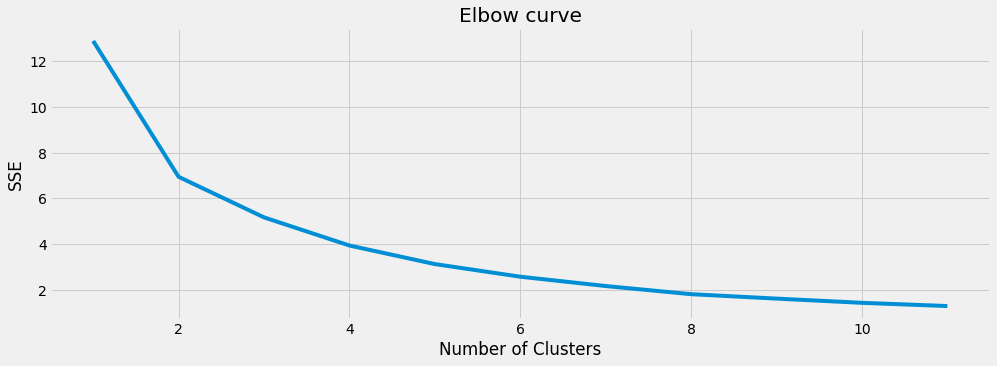

In [373]:
X = returns[['Returns', 'Volatility']]
distorsions = []
# 11 sectors in SP500, we are looking for optimal k for kmeans
for k in range(1, 12):
    kmeans.n_clusters = k
    pipe.fit(X)
    distorsions.append(kmeans.inertia_)
    print(f"Num clusters: {kmeans.n_clusters}")

fig = plt.figure(figsize=(15, 5))
plt.style.use('fivethirtyeight')
plt.plot(range(1, 12), distorsions)
plt.xlabel('Number of Clusters')
plt.ylabel("SSE")
plt.title('Elbow curve')
plt.grid(True)
plt.show()

In [374]:
from kneed import KneeLocator
kl = KneeLocator(
     range(1, 12), distorsions, S=1.0, curve="convex", direction="decreasing")
# kmeans_kwargs['n_clusters'] = kl.elbow
kmeans.n_clusters = kl.elbow
kl.elbow

4

In [377]:
predicted_labels = kmeans.fit(X).labels_
predicted_labels

array([1, 1, 1, 2, 1, 2, 2, 3, 2, 2, 1, 1, 1, 1, 0, 2, 1, 2, 0, 1, 1, 1,
       1, 1, 1, 2, 1, 1, 0, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 1,
       0, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1, 2,
       2, 0, 1, 0, 2, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 2, 0, 3, 2, 2,
       1, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2, 1, 2, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 2, 2, 0, 1, 1, 2, 1, 1, 2, 1,
       0, 2, 2, 0, 1, 0, 0, 0, 1, 0, 2, 2, 0, 1, 2, 1, 2, 1, 0, 1, 1, 1,
       2, 0, 2, 1, 1, 1, 1, 2, 2, 1, 3, 1, 0, 1, 1, 1, 1, 1, 3, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1,
       2, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 2, 1, 1, 1, 2, 1, 2, 0, 0, 2, 2,
       2, 2, 1, 1, 0, 2, 2, 0, 1, 1, 1, 1, 2, 0, 2, 2, 2, 1, 1, 2, 1, 1,
       2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 1, 0, 2, 1, 0, 1, 2, 1, 1, 0, 1, 1, 2, 2, 2, 2, 1, 2, 1, 0,
       1, 2, 2, 1, 1, 2, 3, 2, 2, 0, 0, 2, 2, 1, 2,

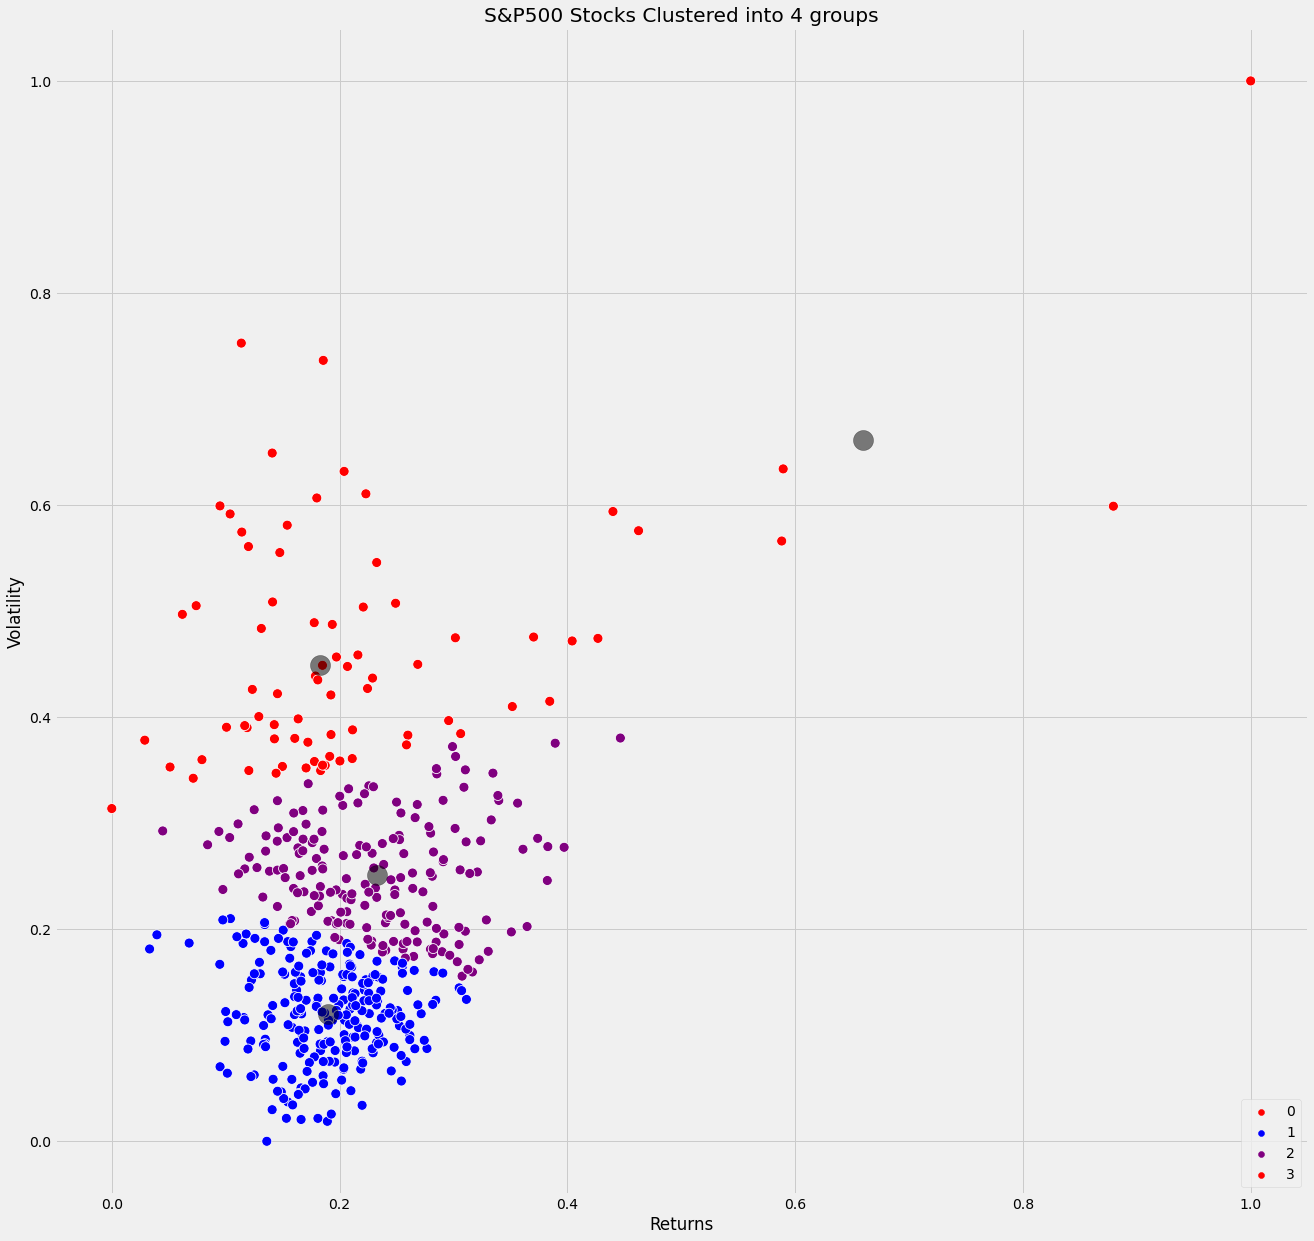

In [378]:
fig = plt.figure(figsize=(20, 20))
colors = ['red', 'blue', 'purple', 'red']
sns.scatterplot(x='Returns', y='Volatility', hue=predicted_labels, data=returns, palette=colors, s=100)
plt.legend(loc='lower right')
plt.grid(True)
plt.title("S&P500 Stocks Clustered into 4 groups")
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=400, alpha=0.5);

In [381]:
# remove outliers from data set to get a more clear kmeans clustering
returns_rm_outliers = returns[(returns['Returns'] < 0.4) & (returns['Volatility'] < 0.6)]
data = np.asarray([np.asarray(returns['Returns']),np.asarray(returns['Volatility'])]).T

In [389]:
predicted_labels = kmeans.fit(returns_rm_outliers[['Returns', 'Volatility']]).labels_
centers = kmeans.cluster_centers_

In [383]:
returns_rm_outliers['predicted_label'] = predicted_labels
print(returns_rm_outliers['predicted_label'])
print(kmeans.n_clusters)

MMM     0
ABT     0
ABBV    0
ABMD    3
ACN     0
       ..
YUM     0
ZBRA    3
ZBH     0
ZION    2
ZTS     0
Name: predicted_label, Length: 488, dtype: int32
4


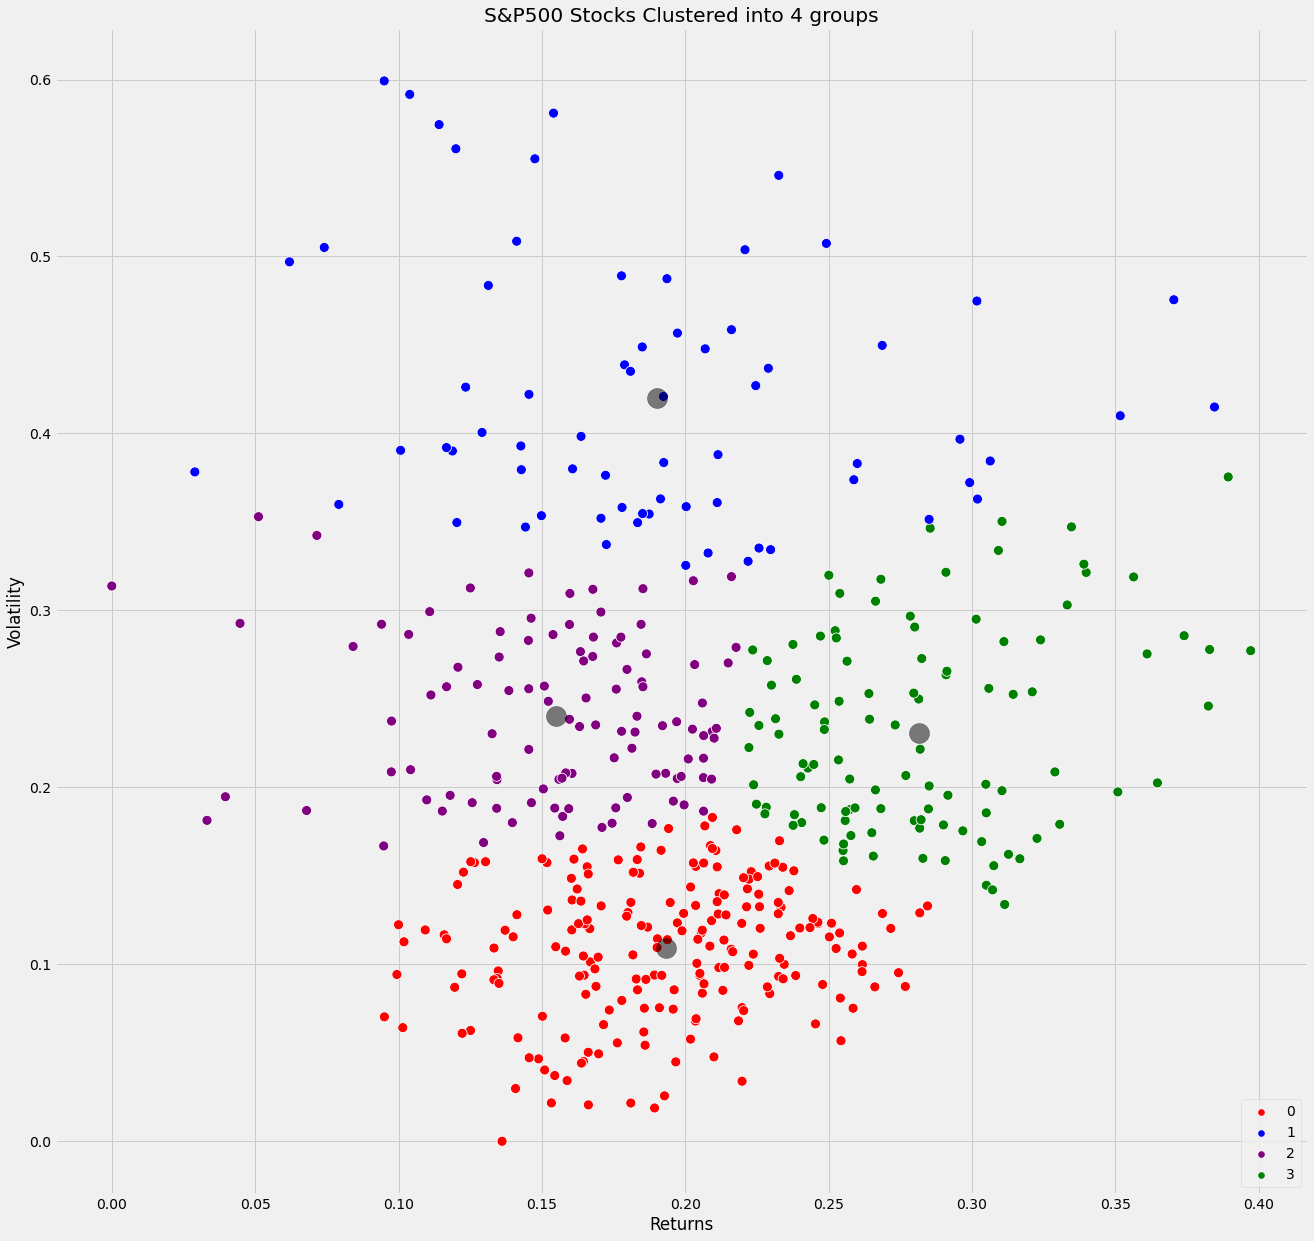

In [390]:
fig = plt.figure(figsize=(20, 20))
colors = ['red', 'blue', 'purple', 'green']
sns.scatterplot(x='Returns', y='Volatility', hue='predicted_label', data=returns_rm_outliers, palette=colors, s=100)
plt.legend(loc='lower right')
plt.grid(True)
plt.title("S&P500 Stocks Clustered into 4 groups")
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=400, alpha=0.5);